In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [3]:
df =pd.read_sql_table('coffee_machine', 'sqlite:///dissertation.db') 

In [4]:
df

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,0.0,-1,0,0,0,weekday,0.0
1,2019-12-23 00:00:10,0.0,-1,0,0,0,weekday,0.0
2,2019-12-23 00:00:20,0.0,-1,0,0,0,weekday,0.0
3,2019-12-23 00:00:30,0.0,-1,0,0,0,weekday,0.0
4,2019-12-23 00:00:40,0.0,-1,0,0,0,weekday,0.0
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,0.0,23,6,23,59,holiday,0.0
1451516,2020-06-07 23:59:20,0.0,23,6,23,59,holiday,0.0
1451517,2020-06-07 23:59:30,0.0,23,6,23,59,holiday,0.0
1451518,2020-06-07 23:59:40,0.0,23,6,23,59,holiday,0.0


In [5]:
df_copy = df.copy()

In [6]:
# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [174]:
# prepare data for clustering
df_half['weekofyear']=df_half.index.week
df_half['day_categ']=df_half.index.day_name()
df_half['day_num']=df_half.index.weekday
#df_half['day']=df_half.index.day
df_half['hour']=df_half.index.hour


# prepare day_type --> weekday, weekend, holiday
df_half['day_type'] = df_half['day_num'].apply(lambda x: 'weekday' if x <5 else 'weekend')
df_half.loc[(df_half.index >= '2019-12-24 00:00:00') & (df_half.index < '2019-12-26 00:00:00'), 'day_type']='holiday'
df_half.loc[(df_half.index >= '2020-01-01 00:00:00') & (df_half.index < '2020-01-02 00:00:00'), 'day_type']='holiday'

# prepare morning, afternoon, and night 
df_half['time_of_day'] =df_half['hour'].apply(lambda x: 'morning' if (x>=7) & (x<= 12) else ('afternoon' if (x>12) & (x<=18) else 'night'))

# lockdown
df_half.loc[(df_half.weekofyear >=12) & (df_half.weekofyear <24), 'day_type'] = 'holiday'


df_half['hour']=df_half.index.strftime('%H')

In [175]:
# subset dataset without lockdown for train and test, lockdown data for prediction 
subset_num = 4368
df_train_test = df_half[['Half_Wh']][:subset_num]
df_valid = df_half[['Half_Wh']][subset_num:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

valid=df_valid.values
valid=valid.astype('float32')

In [176]:
# split into train and test sets
train_size = int(len(train_test) * 0.65)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

2839 1529


In [177]:
# manipulate data to x,and y
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [178]:
# create train and test dataset, and vaild dataset
look_back=96
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
validX, validY = create_dataset(valid, look_back)

In [179]:
# add extra variables day_type and time of the day

# extract the train variables for same length
df_train_var=df_half[['day_categ','time_of_day','day_type']][:len(trainX)]
# get dummies
df_dum_train=pd.get_dummies(df_train_var)

# extract the test variables for same length
df_test_var=df_half[['day_categ','time_of_day','day_type']][len(trainX):len(trainX)+len(testX)]
# get dummies
df_dum_test=pd.get_dummies(df_test_var)

# extract the validation variables for same length
df_valid_var=df_half[['day_categ','time_of_day','day_type']][len(trainX)+len(testX):len(trainX)+len(testX)+len(validX)]
# get dummies
df_dum_valid=pd.get_dummies(df_valid_var)
df_dum_valid['day_type_weekday']=0
df_dum_valid['day_type_weekend']=0

In [180]:
#to np
np_train=np.array(df_dum_train)

#to np
np_test=np.array(df_dum_test)

#to np
np_valid=np.array(df_dum_valid)

In [181]:
#concatenate trainX, testX, validX with variables, respectively
trainX_ok = np.concatenate((trainX, np_train),axis=1)
testX_ok = np.concatenate((testX, np_test),axis=1)
validX_ok = np.concatenate((validX, np_valid),axis=1)

In [183]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(193, input_dim=look_back, activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae','mape'])
history = model.fit(trainX_ok, trainY, epochs=200, batch_size=10, verbose=2)

Epoch 1/200
 - 2s - loss: 2115.2691 - mse: 2115.2683 - mae: 26.3086 - mape: 9776770048.0000
Epoch 2/200
 - 1s - loss: 1611.2520 - mse: 1611.2518 - mae: 21.3534 - mape: 6585530880.0000
Epoch 3/200
 - 1s - loss: 1426.2733 - mse: 1426.2729 - mae: 20.0157 - mape: 6076678656.0000
Epoch 4/200
 - 1s - loss: 1278.5960 - mse: 1278.5959 - mae: 18.6880 - mape: 5451516928.0000
Epoch 5/200
 - 1s - loss: 1071.2009 - mse: 1071.2008 - mae: 17.0409 - mape: 4839370240.0000
Epoch 6/200
 - 1s - loss: 917.9763 - mse: 917.9765 - mae: 15.6384 - mape: 4291391232.0000
Epoch 7/200
 - 1s - loss: 750.7132 - mse: 750.7132 - mae: 13.9267 - mape: 3708667136.0000
Epoch 8/200
 - 1s - loss: 597.6557 - mse: 597.6557 - mae: 12.6586 - mape: 3371436544.0000
Epoch 9/200
 - 1s - loss: 481.0393 - mse: 481.0393 - mae: 11.3290 - mape: 2989613056.0000
Epoch 10/200
 - 1s - loss: 417.4714 - mse: 417.4716 - mae: 10.3524 - mape: 2769501184.0000
Epoch 11/200
 - 1s - loss: 377.8228 - mse: 377.8228 - mae: 9.8553 - mape: 2644432640.0000

Epoch 94/200
 - 1s - loss: 56.7245 - mse: 56.7245 - mae: 3.0944 - mape: 600355136.0000
Epoch 95/200
 - 1s - loss: 45.5123 - mse: 45.5123 - mae: 2.8506 - mape: 529922080.0000
Epoch 96/200
 - 1s - loss: 52.8279 - mse: 52.8279 - mae: 3.1064 - mape: 574087168.0000
Epoch 97/200
 - 1s - loss: 38.7681 - mse: 38.7681 - mae: 2.7659 - mape: 582123712.0000
Epoch 98/200
 - 1s - loss: 35.8339 - mse: 35.8339 - mae: 2.5345 - mape: 483755744.0000
Epoch 99/200
 - 1s - loss: 46.2922 - mse: 46.2922 - mae: 2.9476 - mape: 600122496.0000
Epoch 100/200
 - 1s - loss: 66.5778 - mse: 66.5778 - mae: 3.4869 - mape: 655299968.0000
Epoch 101/200
 - 1s - loss: 68.8368 - mse: 68.8368 - mae: 3.5603 - mape: 644274304.0000
Epoch 102/200
 - 1s - loss: 60.0287 - mse: 60.0287 - mae: 3.4105 - mape: 599067328.0000
Epoch 103/200
 - 1s - loss: 52.7092 - mse: 52.7092 - mae: 3.1541 - mape: 560024576.0000
Epoch 104/200
 - 1s - loss: 44.4925 - mse: 44.4925 - mae: 2.8375 - mape: 524797280.0000
Epoch 105/200
 - 1s - loss: 43.7246 - 

Epoch 188/200
 - 1s - loss: 24.5592 - mse: 24.5592 - mae: 1.9844 - mape: 389755840.0000
Epoch 189/200
 - 1s - loss: 22.7619 - mse: 22.7619 - mae: 1.8187 - mape: 297958464.0000
Epoch 190/200
 - 1s - loss: 33.2027 - mse: 33.2027 - mae: 2.4048 - mape: 507732960.0000
Epoch 191/200
 - 1s - loss: 32.3139 - mse: 32.3139 - mae: 2.3408 - mape: 425698048.0000
Epoch 192/200
 - 1s - loss: 44.1006 - mse: 44.1006 - mae: 2.7370 - mape: 565844160.0000
Epoch 193/200
 - 1s - loss: 33.9577 - mse: 33.9577 - mae: 2.4292 - mape: 493525472.0000
Epoch 194/200
 - 1s - loss: 28.0796 - mse: 28.0796 - mae: 2.1200 - mape: 395226944.0000
Epoch 195/200
 - 1s - loss: 25.3557 - mse: 25.3557 - mae: 1.9273 - mape: 335361056.0000
Epoch 196/200
 - 1s - loss: 18.4788 - mse: 18.4787 - mae: 1.6407 - mape: 295381088.0000
Epoch 197/200
 - 1s - loss: 16.5465 - mse: 16.5465 - mae: 1.5238 - mape: 280117280.0000
Epoch 198/200
 - 1s - loss: 17.1634 - mse: 17.1634 - mae: 1.5333 - mape: 283384608.0000
Epoch 199/200
 - 1s - loss: 20.2

In [185]:
# model evalute
trainScore = model.evaluate(trainX_ok, trainY)
testScore = model.evaluate(testX_ok, testY)
validScore = model.evaluate(validX_ok, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2] )
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])
print('Valid MSE: ', validScore[1], 'MAE: ', validScore[2])

3599/3599 [==============================] - 0s 132us/step
Train MSE:  29.990549087524414 MAE:  2.415473222732544
Test MSE:  1610.8699951171875 MAE:  18.323402404785156
Valid MSE:  104.62738800048828 MAE:  5.722539901733398


In [186]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
validPredict = model.predict(validX)
nextPredict = model.predict(testX[-1:,:])

In [187]:
print(nextPredict,df_valid[0:1].values)

[[0.11658347]] [[0.]]


In [188]:
from sklearn.metrics import r2_score
r2=r2_score(testY,testPredict)

#mape = np.mean(np.abs(testPredict - testY)/np.abs(testY))  # MAPE

print('R2: ', r2)

R2:  0.44027486030325447


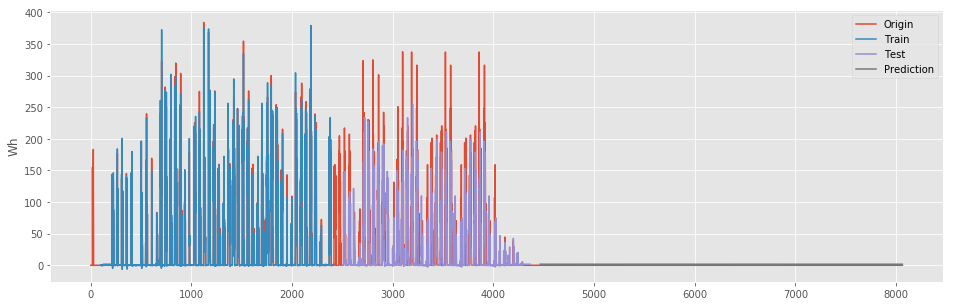

In [142]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,valid),axis=0)
validPredictPlot = np.empty_like(np_all)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(train_test)+look_back:-1, :] = validPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
#plt.plot_date(time,np_all/1000)
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(validPredictPlot,label='Prediction')
plt.ylabel('Wh')
plt.legend()
#plt.gca().set(ylable='kWh')
plt.show()

In [143]:
# add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset_num])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset_num])
df_validPredictPlot = pd.DataFrame(validPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_validPredictPlot], axis=1)

Text(0, 0.5, 'Wh')

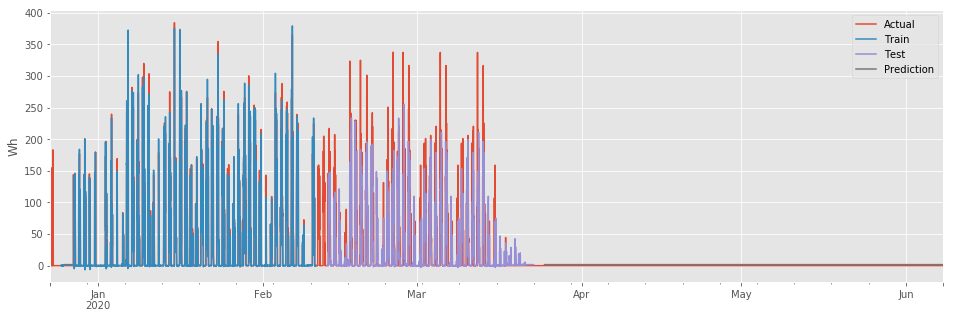

In [164]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

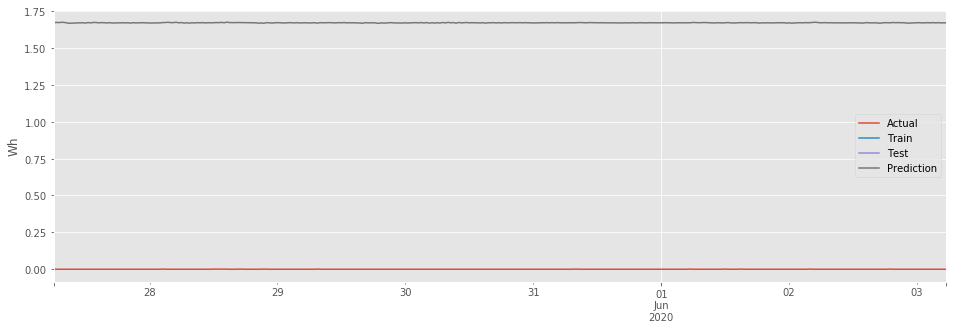

In [165]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

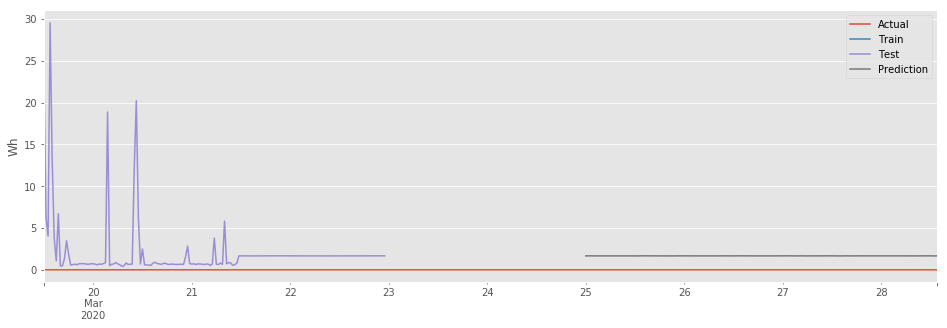

In [166]:
df_all_plot[4200:4636].set_index(df_all_plot[4200:4636].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

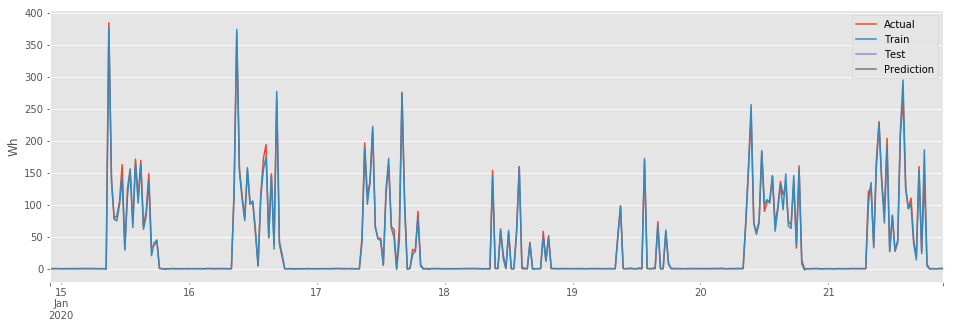

In [167]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [133]:
# save the model 
model.save('coffee_machine_nolock_ann.h5')

In [8]:
# with lockdown
mad_mean_ratio =17.32*1529/df_half['Half_Wh'][4368-1613:4368].sum() 
mad_mean_ratio

0.6179729743693756

In [154]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///ml.db', echo=True) #set the database name as jba.db
sqlite_connection = engine.connect()
sqlite_table = "coffee_machine"       #set the table name as rainfall_data
df.to_sql(sqlite_table, sqlite_connection, if_exists='replace')  # import dataframe to sqlite

2020-08-17 07:48:14,541 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-08-17 07:48:14,623 INFO sqlalchemy.engine.base.Engine ()
2020-08-17 07:48:14,646 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-08-17 07:48:14,649 INFO sqlalchemy.engine.base.Engine ()
2020-08-17 07:48:15,352 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("coffee_machine")
2020-08-17 07:48:15,362 INFO sqlalchemy.engine.base.Engine ()
2020-08-17 07:48:17,343 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE coffee_machine (
	"index" BIGINT, 
	time DATETIME, 
	mean_power FLOAT, 
	weekofyear BIGINT, 
	day_name BIGINT, 
	hour BIGINT, 
	mins BIGINT, 
	day_type TEXT, 
	"kWh" FLOAT
)


2020-08-17 07:48:17,344 INFO sqlalchemy.engine.base.Engine ()
2020-08-17 07:48:17,844 INFO sqlalchemy.engine.base.Engine COMMIT
2020-08-17 07:48:17,860 INFO sqlalchemy.engine.base.Engine CREATE INDEX ix_coffee_machine_index ON coffe